In [69]:
#Standard Imports
import numpy as np
import pandas as pd
import time

#visual libraries
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import sklearn.metrics as mtr
plt.style.use('ggplot')

# sklearn libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,classification_report,roc_curve,precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import itertools

In [70]:
fresh_train_df = pd.read_csv('../data/training_set_(50_50).csv')
fresh_test_df = pd.read_csv('../data/testing_set_(90_10).csv')
df = fresh_train_df
test_df = fresh_test_df.drop(columns="address_used")
new_df = df.drop(columns="address_used")

In [71]:
# Do not delete this cell
features_new_df = fresh_train_df
features_test_df = fresh_test_df
y_train = features_new_df["ponzi"]
y_test = features_test_df["ponzi"]

#removed_features, more_removed_features = ["address_used", "ponzi"], []
removed_features = ["address_used", "maximum_time_between_sent_accounts","minimum_time_between_sent_accounts","average_time_between_sent_accounts","maximum_time_between_received_accounts","minimum_time_between_received_accounts","average_time_between_received_accounts","time_between_first_and_last_transaction", "ponzi"]
more_removed_features = ["account_balance", "account_creation_time","gini_coefficient_accounts_received","gini_coefficient_accounts_sent","gini_coefficient_values_received","gini_coefficient_values_sent"]
#"total_sent_accounts", "total_received_accounts","total_number_of_transactions","total_unique_sent_accounts""total_unique_received_accounts",
removed_features = removed_features + more_removed_features

features_new_df = features_new_df.drop(labels=removed_features,axis=1)
features_test_df = features_test_df.drop(labels=removed_features,axis=1)

# Split of training and testing data - not required after different data sets
# X_train, X_test, y_train, y_test = train_test_split(feature_array, label_array, test_size = 0.20)
# Normalization of data after splitting


In [72]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(features_new_df)
X_test = scaler.transform(features_test_df)
#X_train = normalize(features_new_df)
#X_test = normalize(features_test_df)

#features_new_df.head()

In [73]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

fbeta_scorer = mtr.make_scorer(mtr.fbeta_score, beta=2)
param_grid = {"n_neighbors": np.arange(2, 25)}

knn = KNeighborsClassifier(weights = "distance", algorithm="ball_tree")
knn_gscv = GridSearchCV(knn, param_grid, cv=5, scoring=fbeta_scorer)
knn_gscv.fit(X_train, y_train)
knn_gscv.best_params_

{'n_neighbors': 6}

In [74]:
#X_train = normalize(features_new_df)
#X_test = normalize(features_test_df)

from sklearn.metrics import roc_curve
from sklearn.metrics import auc

#features_new_df.head()

knn=KNeighborsClassifier(n_neighbors=knn_gscv.best_params_['n_neighbors'],weights='distance', algorithm="ball_tree",n_jobs=-1)

#k_nearest_neighbours_classification
knn.fit(X_train,y_train.ravel())
knn_predicted_test_labels=knn.predict(X_test)


In [75]:
def plot_confusion_matrix(cm, classes, normalize = False):
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
    plt.title('Confusion Matrix', size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20, horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

    
def plot_roc_curve(y, prob):
    base_fpr, base_tpr, _ = mtr.roc_curve(y, [1 for _ in range(len(y))])
    model_fpr, model_tpr, _ = mtr.roc_curve(y, prob)
    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'rf')
    plt.legend();
    plt.xlabel('False Positive Rate');
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();

    
def train_test_measure(model, xtr, ytr, xte, yte):
    model.fit(xtr, ytr)
    y_test_pred = model.predict(xte)
    y_test_pred_proba = model.predict_proba(xte)[:,1]

    results = (mtr.precision_recall_fscore_support(yte,y_test_pred,beta = 2))
    # precisionfloat (if average is not None) or array of float, shape = [n_unique_labels]
    # recallfloat (if average is not None) or array of float, shape = [n_unique_labels]
    # fbeta_scorefloat (if average is not None) or array of float, shape = [n_unique_labels]
    
    cm = mtr.confusion_matrix(yte, y_test_pred)
    plot_confusion_matrix(cm, ['0 - Normal', '1 - Ponzi'])

    specificity = cm[0][0] / (cm[0][0] + cm[0][1])
    sensitivity = cm[0][0] / (cm[0][0] + cm[1][0])
    recall = mtr.recall_score(yte,y_test_pred)
    print('accuracy:', mtr.accuracy_score(yte,y_test_pred))
    print('precision non-fraud :', results[0][0], 'precision fraud :', results[0][1])
    print('recall non-fraud:', results[1][0], "recall fraud", results[1][1])
    print('f2 non-fraud', results[2][0], "f2 fraud : ", results[2][1]  )
    print('sensitivity', sensitivity)
    print('specificity:', specificity)
    print('g mean: ', (recall*specificity)**0.5)
    print('auc:', mtr.roc_auc_score(yte, y_test_pred_proba))
    plot_roc_curve(yte, y_test_pred_proba)
    

accuracy: 0.6375275055011003
precision non-fraud : 0.9699300699300699 accuracy fraud : 0.19308087891538103
recall non-fraud: 0.6164444444444445 precision fraud 0.8276553106212425
f2 non-fraud 0.664908916586769 f2 fraud :  0.49939540507859737
sensitivity 0.9699300699300699
specificity: 0.6164444444444445
g mean:  0.7142853198459324
auc: 0.7985397461589845


C:\Users\daryl\AppData\Local\Temp/ipykernel_14960/1021338315.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(aspect=4)


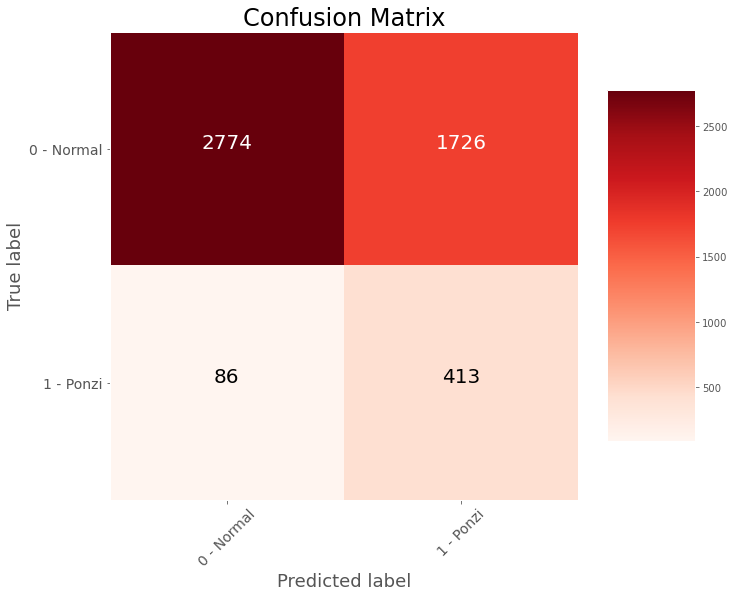

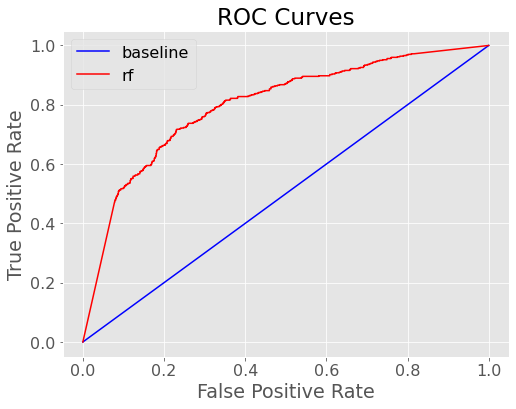

In [76]:
train_test_measure(knn, X_train, y_train, X_test, y_test)

In [77]:

'''
print(classification_report(y_test, knn_predicted_test_labels))
print(precision_recall_fscore_support(y_test, knn_predicted_test_labels,beta=2))

conf_matrix = confusion_matrix(y_test, knn_predicted_test_labels)
print(conf_matrix)  

LABELS = ['Normal', 'Fraud']
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

y_scores = knn.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()
'''

'\nprint(classification_report(y_test, knn_predicted_test_labels))\nprint(precision_recall_fscore_support(y_test, knn_predicted_test_labels,beta=2))\n\nconf_matrix = confusion_matrix(y_test, knn_predicted_test_labels)\nprint(conf_matrix)  \n\nLABELS = [\'Normal\', \'Fraud\']\nplt.figure(figsize=(12, 12))\nsns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")\nplt.title("Confusion matrix")\nplt.ylabel(\'True class\')\nplt.xlabel(\'Predicted class\')\nplt.show()\n\ny_scores = knn.predict_proba(X_test)\nfpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])\nroc_auc = auc(fpr, tpr)\n\nplt.title(\'Receiver Operating Characteristic\')\nplt.plot(fpr, tpr, \'b\', label = \'AUC = %0.2f\' % roc_auc)\nplt.legend(loc = \'lower right\')\nplt.plot([0, 1], [0, 1],\'r--\')\nplt.xlim([0, 1])\nplt.ylim([0, 1])\nplt.ylabel(\'True Positive Rate\')\nplt.xlabel(\'False Positive Rate\')\nplt.title(\'ROC Curve of kNN\')\nplt.show()\n'